In [1]:
%matplotlib inline 
import torch
import torch.optim as optim # будем использовать adam optimizer отсюда
from torchvision import transforms, models #использовать преобразования для выполнения различных преобразований изображения, модели foe vgg19
from PIL import Image #чтобы открыть наше изображение и выполнить над ним операции
import matplotlib.pyplot as plt
import numpy as np
from pathlib import *

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False) # установка параметра feature params false, чтобы мы могли использовать параметры по умолчанию этой модели

In [5]:
# использовать графический процессор, предоставленный нам компанией pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(img_path, max_size=400, shape=None): #max_size это максимальный размер, который мы хотим получить от нашего изображения. Shape определяется для того, чтобы размеры изображения содержимого и изображения стиля были одинаковыми.
    
    image = Image.open(img_path).convert('RGB') #Откройте изображение и преобразуйте его в RGB
    if max(image.size) > max_size: # Установите максимальный размер, который мы определили
        size = max_size            
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape    # если форма вызвана, мы просто меняем изображения, чтобы сделать размеры одинаковыми.
    # выполняем преобразования на нашем i/p изображении
    in_transform = transforms.Compose([                
                        transforms.Resize(size), 
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0) # добавляем особый размер
    
    return image

In [7]:
directory = Path(r"C:\VKR\Photo")
content = load_image(directory/"zL8SwZXv0JA.jpg").to(device) # для устройства, на котором работает наша модель
noise =  load_image(directory/"Noise2.jpg").to(device) 

In [8]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze() # уменьшить размерность, чтобы сопоставить ее с осью субплощадок
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

In [9]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

(-0.5, 399.5, 429.5, -0.5)

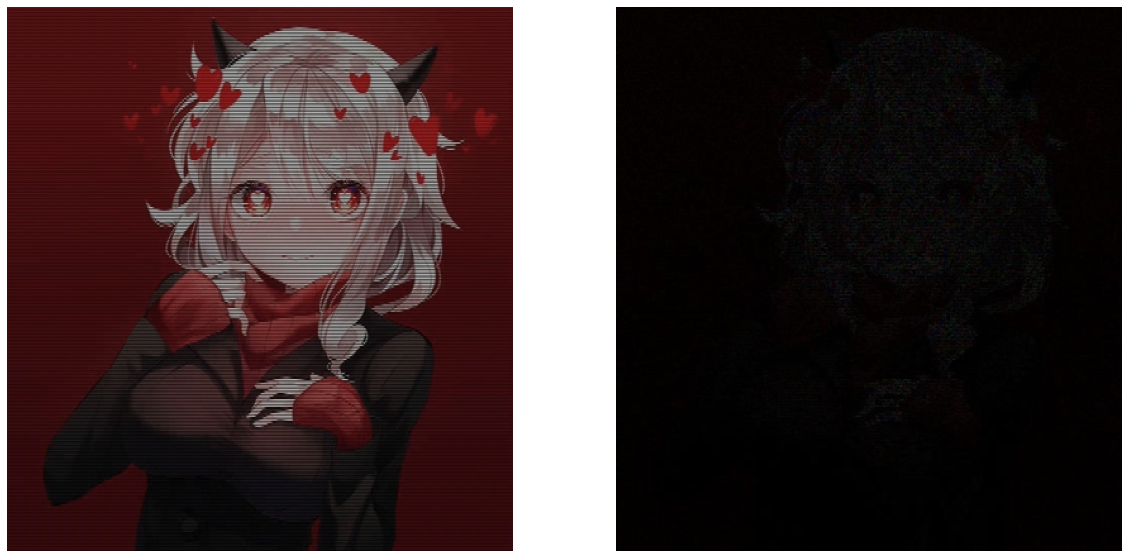

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(noise))
ax2.axis("off")

In [11]:
def get_features(image, model): # получить характеристики из указанных слоев.
   
    layers = {
              '21': 'conv4_2',  # Извлечение содержимого
              }
        
    features = {} 

    for name, layer in model._modules.items(): # сначала мы пройдемся по каждому слою vgg19.
        image = layer(image)                   # и затем пропускаем наше входное изображение через каждый слой.
        if name in layers:                     # затем мы сохраняем выходы только тех слоев, которые нам нужны, в нашем словаре характеристик
            features[layers[name]] = image     
            
    return features 

In [12]:
content_features = get_features(content, vgg)
Noise_features = get_features(noise,vgg)

In [13]:
content_weight = 1

In [14]:
target = content.clone().requires_grad_(True).to(device)

In [15]:
show_every = 200     # Мы показываем результаты итераций после каждых 50 изображений.
optimizer = optim.Adam([target], lr=0.003)  # Мы просто корректируем параметры целевого изображения.
steps = 1000 # Количество итераций, которые мы хотим сделать для достижения лучшей точности. Чем больше шагов, тем выше точность.

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  0.009430047124624252
Iteration:  1000


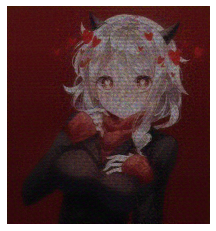

Total loss:  0.004340867046266794
Iteration:  2000


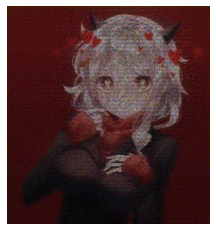

Total loss:  0.002677608048543334
Iteration:  3000


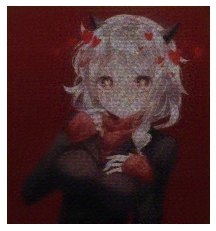

Total loss:  0.001872945693321526
Iteration:  4000


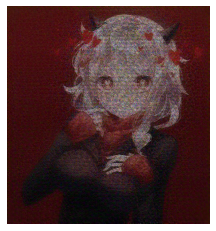

Total loss:  0.0014542475109919906
Iteration:  5000


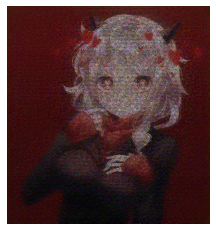

Total loss:  0.0011880106758326292
Iteration:  6000


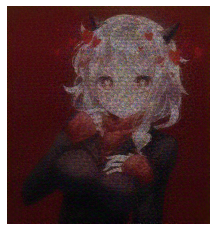

Total loss:  0.0010404200293123722
Iteration:  7000


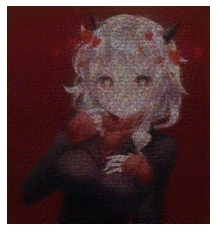

Total loss:  0.0009650966385379434
Iteration:  8000


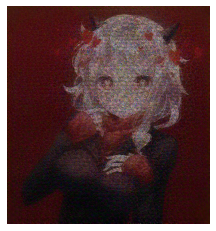

Total loss:  0.0008405554690398276
Iteration:  9000


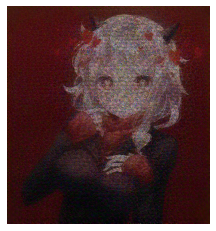

In [16]:
for ii in range(1, steps+1): 
  target_features = get_features(target, vgg) # Сначала мы получаем все признаки для целевого изображения, когда оно помещается в предварительно обученную модель vgg19.
  content_loss = torch.mean((target_features['conv4_2'] - Noise_features['conv4_2'])**2) # Затем мы вычитаем эти значения характеристик из значений характеристик contect_image для того же слоя, чтобы получить потери.
  style_loss = 0
  
  total_loss = content_weight * content_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:   # Показывать прогресс вывода изображения после каждых 50 шагов.
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0: # Store the output frames after every 30 steps to get total 300 frames for video processing later.
    image_array[counter] = im_convert(target)
    counter = counter + 1

(-0.5, 399.5, 429.5, -0.5)

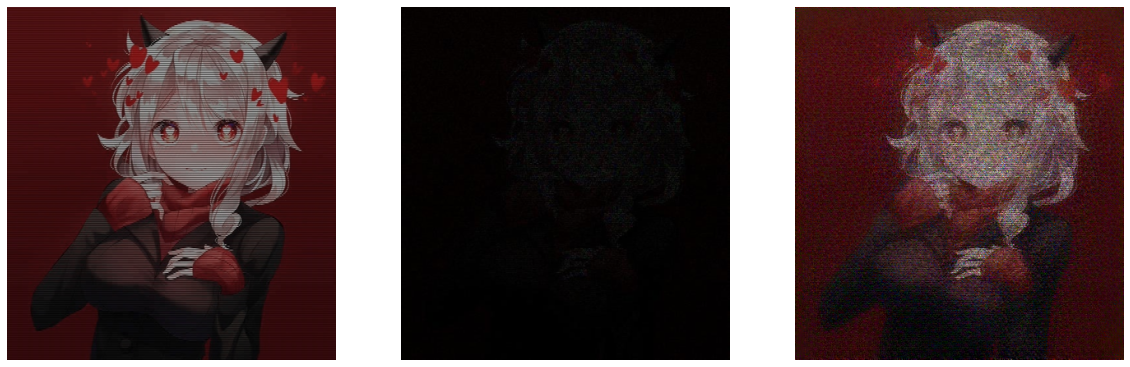

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(noise))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [2]:
torch.cuda.is_available()

True